# Introduction to python for hydrologists &mdash; pandas

<img src = "./data/pandas/panda.jpg">

## Not that type of Panda -- Python's Pandas package

Pandas is a powerful, flexible and easy to use open source data analysis and manipulation tool. Pandas is commonly used for operations that would normally be done in a spreadsheet environment and includes powerful data analysis and manipulation tools.

Let's begin by importing the libraries and setting our data path 

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pygeohydro as gh
import datetime 
import statsmodels.api as sm
from matplotlib.backends.backend_pdf import PdfPages

data_path = os.path.join("data", "pandas")

## Get site information data for part of the Russian River near Guerneville, CA from NWIS 

In [2]:
bbox = (-123.10, 38.45, -122.90, 38.55)
gh.interactive_map(bbox)

Wow that's a lot of gages in this location, let's info on all of them and then use this data to learn about pandas

In [3]:
query = {"bBox": ",".join(f"{b :.6f}" for b in bbox)}

nwis = gh.NWIS()
info = nwis.get_info(query)
info

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,drain_sqkm,hcdn_2009,geometry
0,USGS,11467000,"Russian R A Hacienda Bridge Nr Guerneville, CA",ST,38.508523,-122.927774,F,NAD83,20.14,0.01,NGVD29,18010110,3465.2020,False,POINT (-122.92777 38.50852)
1,USGS,11467002,"Russian R A Johnsons Beach A Guerneville, CA",ST,38.499358,-122.998333,F,NAD83,8.79,0.10,NGVD29,18010110,NaN,False,POINT (-122.99833 38.49936)
2,USGS,11467006,"Russian R A Vacation Beach, CA",ST,38.484080,-123.012500,F,NAD83,2.00,20.00,NGVD29,18010110,NaN,False,POINT (-123.01250 38.48408)
3,USGS,11467050,"Big Austin C A Cazadero, CA",ST,38.537413,-123.089447,F,NAD83,NaN,NaN,,18010110,NaN,False,POINT (-123.08945 38.53741)
4,USGS,11467200,"Austin C Nr Cazadero, CA",ST,38.506580,-123.069724,S,NAD83,40.00,20.00,NGVD29,18010110,162.6129,False,POINT (-123.06972 38.50658)
5,USGS,11467210,"Russian R A Duncans Mills, CA",ST,38.453525,-123.049446,F,NAD83,NaN,NaN,,18010110,NaN,False,POINT (-123.04945 38.45353)
6,USGS,382701123025801,"Freezeout C Nr Duncans Mills, CA",ST,38.450278,-123.049444,U,NAD83,12.00,20.00,NGVD29,18010110,NaN,False,POINT (-123.04944 38.45028)
7,USGS,382752123003401,"Dutch Bill C A Monte Rio, CA",ST,38.464444,-123.009444,U,NAD83,45.00,20.00,NGVD29,18010110,NaN,False,POINT (-123.00944 38.46444)
8,USGS,382754123030501,"Russian R A Casini Ranch Nr Duncans Mills, CA",ST,38.465000,-123.051389,F,NAD83,5.00,20.00,NGVD29,18010110,NaN,False,POINT (-123.05139 38.46500)
9,USGS,382757123003801,"Russian R A Monte Rio, CA",ST,38.465833,-123.010556,F,NAD83,5.00,20.00,NGVD29,18010110,NaN,False,POINT (-123.01056 38.46583)


The data returned to us from our NWIS query `info` was returned to us as pandas `DataFrame`. We'll be working with this to start learning about the basics of pandas.

## Viewing data in pandas

Pandas has built in methods to inspect `DataFrame` objects. We'll look at a few handy methods:

   - `.head()`: inspect the first few rows of data
   - `.tail()`: inspect the last few rows of data
   - `.index()`: show the row indexes
   - `.columns()`: show the column names
   - `.describe()`: statistically describe the data

In [4]:
info.head()

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,drain_sqkm,hcdn_2009,geometry
0,USGS,11467000,"Russian R A Hacienda Bridge Nr Guerneville, CA",ST,38.508523,-122.927774,F,NAD83,20.14,0.01,NGVD29,18010110,3465.2020,False,POINT (-122.92777 38.50852)
1,USGS,11467002,"Russian R A Johnsons Beach A Guerneville, CA",ST,38.499358,-122.998333,F,NAD83,8.79,0.10,NGVD29,18010110,NaN,False,POINT (-122.99833 38.49936)
2,USGS,11467006,"Russian R A Vacation Beach, CA",ST,38.484080,-123.012500,F,NAD83,2.00,20.00,NGVD29,18010110,NaN,False,POINT (-123.01250 38.48408)
3,USGS,11467050,"Big Austin C A Cazadero, CA",ST,38.537413,-123.089447,F,NAD83,NaN,NaN,,18010110,NaN,False,POINT (-123.08945 38.53741)
4,USGS,11467200,"Austin C Nr Cazadero, CA",ST,38.506580,-123.069724,S,NAD83,40.00,20.00,NGVD29,18010110,162.6129,False,POINT (-123.06972 38.50658)


In [5]:
info.tail()

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,drain_sqkm,hcdn_2009,geometry
20,USGS,383009122543001,"Green Valley C Nr Mirabel Heights, CA",ST,38.502500,-122.908333,U,NAD83,71.0,20.0,NGVD29,18010110,NaN,False,POINT (-122.90833 38.50250)
21,USGS,383012122574501,"Russian R A Odd Fellows Park Nr Rio Nido, CA",ST,38.503333,-122.962500,F,NAD83,40.0,20.0,NGVD29,18010110,NaN,False,POINT (-122.96250 38.50333)
22,USGS,383016123041101,008N011W27N001M,GW,38.504528,-123.069722,5,NAD83,63.0,1.6,NAVD88,18010110,NaN,False,POINT (-123.06972 38.50453)
23,USGS,383028122554501,"Hobson C Nr Hacienda, CA",ST,38.507778,-122.929167,U,NAD83,60.0,20.0,NGVD29,18010110,NaN,False,POINT (-122.92917 38.50778)
24,USGS,383034122590701,008N010W29H004M,GW,38.509556,-122.985528,5,NAD83,43.0,1.6,NAVD88,18010110,NaN,False,POINT (-122.98553 38.50956)


In [6]:
# print the index names
print(info.index)

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24],
           dtype='int64')


In [7]:
# print the column names
print(info.columns)

# print the column names as a list
print(list(info))

Index(['agency_cd', 'site_no', 'station_nm', 'site_tp_cd', 'dec_lat_va',
       'dec_long_va', 'coord_acy_cd', 'dec_coord_datum_cd', 'alt_va',
       'alt_acy_va', 'alt_datum_cd', 'huc_cd', 'drain_sqkm', 'hcdn_2009',
       'geometry'],
      dtype='object')
['agency_cd', 'site_no', 'station_nm', 'site_tp_cd', 'dec_lat_va', 'dec_long_va', 'coord_acy_cd', 'dec_coord_datum_cd', 'alt_va', 'alt_acy_va', 'alt_datum_cd', 'huc_cd', 'drain_sqkm', 'hcdn_2009', 'geometry']


The `describe()` method is only useful for numerical data. This example is does not have a lot of useful data for `describe()`, however we'll use it agian later

In [8]:
info.describe()

,dec_lat_va,dec_long_va,alt_va,alt_acy_va,drain_sqkm
count,25.000000,25.000000,23.000000,23.000000,2.000000
mean,38.490956,-122.989798,44.040435,11.865652,1813.907450
std,0.021226,0.060306,41.449315,9.492186,2335.283148
min,38.450278,-123.089447,2.000000,0.010000,162.612900
25%,38.470833,-123.046111,21.570000,1.600000,988.260175
50%,38.500528,-123.001667,43.000000,20.000000,1813.907450
75%,38.503333,-122.929167,48.000000,20.000000,2639.554725
max,38.537413,-122.901222,211.000000,20.000000,3465.202000


## Getting data from a pandas dataframe

There are multiple methods to get data out of a pandas dataframe as either a "series", numpy array, or a list

Let's start by getting data as a series using a few methods

In [9]:
# get a series of site numbers by key
info["site_no"]

0            11467000
1            11467002
2            11467006
3            11467050
4            11467200
5            11467210
6     382701123025801
7     382752123003401
8     382754123030501
9     382757123003801
10    382808122565401
11    382815123024601
12    382819123010001
13    382944123002901
14    382955122594101
15    383001122540701
16    383003122540401
17    383003122540402
18    383003122540403
19    383006123000601
20    383009122543001
21    383012122574501
22    383016123041101
23    383028122554501
24    383034122590701
Name: site_no, dtype: object

In [10]:
# get station names by attribute
info.station_nm

0     Russian R A Hacienda Bridge Nr Guerneville, CA
1       Russian R A Johnsons Beach A Guerneville, CA
2                     Russian R A Vacation Beach, CA
3                        Big Austin C A Cazadero, CA
4                           Austin C Nr Cazadero, CA
5                      Russian R A Duncans Mills, CA
6                   Freezeout C Nr Duncans Mills, CA
7                       Dutch Bill C A Monte Rio, CA
8      Russian R A Casini Ranch Nr Duncans Mills, CA
9                          Russian R A Monte Rio, CA
10                                   007N010W10H001M
11                     Austin C Nr Duncans Mills, CA
12                                   007N010W07D001M
13                      Hulbert C Nr Guerneville, CA
14                    Pocket Cyn C A Guerneville, CA
15                                   008N009W31C002M
16                                   008N009W31C003M
17                                   008N009W31C004M
18                                   008N009W3

getting data from a dataframe as a numpy array can be accomplished by using `.values`

In [11]:
info.station_nm.values

array(['Russian R A Hacienda Bridge Nr Guerneville, CA',
       'Russian R A Johnsons Beach A Guerneville, CA',
       'Russian R A Vacation Beach, CA', 'Big Austin C A Cazadero, CA',
       'Austin C Nr Cazadero, CA', 'Russian R A Duncans Mills, CA',
       'Freezeout C Nr Duncans Mills, CA', 'Dutch Bill C A Monte Rio, CA',
       'Russian R A Casini Ranch Nr Duncans Mills, CA',
       'Russian R A Monte Rio, CA', '007N010W10H001M',
       'Austin C Nr Duncans Mills, CA', '007N010W07D001M',
       'Hulbert C Nr Guerneville, CA', 'Pocket Cyn C A Guerneville, CA',
       '008N009W31C002M', '008N009W31C003M', '008N009W31C004M',
       '008N009W31C005M', 'Fife C A Guerneville, CA',
       'Green Valley C Nr Mirabel Heights, CA',
       'Russian R A Odd Fellows Park Nr Rio Nido, CA', '008N011W27N001M',
       'Hobson C Nr Hacienda, CA', '008N010W29H004M'], dtype=object)

### Selection by position

We can get data by position in the dataframe using the `.iloc` attribute 

In [12]:
info.iloc[0:2, 1:4]

,site_no,station_nm,site_tp_cd
0,11467000,"Russian R A Hacienda Bridge Nr Guerneville, CA",ST
1,11467002,"Russian R A Johnsons Beach A Guerneville, CA",ST


### Selection by label

Pandas allows the user to get data from the dataframe by index and column labels

In [13]:
info.loc[0:3, ["site_no", "station_nm", "site_tp_cd"]]

,site_no,station_nm,site_tp_cd
0,11467000,"Russian R A Hacienda Bridge Nr Guerneville, CA",ST
1,11467002,"Russian R A Johnsons Beach A Guerneville, CA",ST
2,11467006,"Russian R A Vacation Beach, CA",ST
3,11467050,"Big Austin C A Cazadero, CA",ST


### Boolean indexing

pandas dataframes supports boolean indexing that allows a user to create a new dataframe with only the data that meets a boolean condition defined by the user.

Let's get a dataframe of only groundwater sites from the `info` dataframe

In [14]:
dfgw = info[info["site_tp_cd"] == "GW"]
dfgw

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,drain_sqkm,hcdn_2009,geometry
10,USGS,382808122565401,007N010W10H001M,GW,38.469028,-122.948389,5,NAD83,211.0,1.6,NAVD88,18010110,NaN,False,POINT (-122.94839 38.46903)
12,USGS,382819123010001,007N010W07D001M,GW,38.472194,-123.016889,5,NAD83,42.0,1.6,NAVD88,18010110,NaN,False,POINT (-123.01689 38.47219)
15,USGS,383001122540701,008N009W31C002M,GW,38.500528,-122.902139,5,NAD83,58.0,1.6,NAVD88,18010110,NaN,False,POINT (-122.90214 38.50053)
16,USGS,383003122540401,008N009W31C003M,GW,38.500917,-122.901222,1,NAD83,48.0,1.6,NAVD88,18010110,NaN,False,POINT (-122.90122 38.50092)
17,USGS,383003122540402,008N009W31C004M,GW,38.500917,-122.901222,1,NAD83,48.0,1.6,NAVD88,18010110,NaN,False,POINT (-122.90122 38.50092)
18,USGS,383003122540403,008N009W31C005M,GW,38.500917,-122.901222,1,NAD83,48.0,1.6,NAVD88,18010110,NaN,False,POINT (-122.90122 38.50092)
22,USGS,383016123041101,008N011W27N001M,GW,38.504528,-123.069722,5,NAD83,63.0,1.6,NAVD88,18010110,NaN,False,POINT (-123.06972 38.50453)
24,USGS,383034122590701,008N010W29H004M,GW,38.509556,-122.985528,5,NAD83,43.0,1.6,NAVD88,18010110,NaN,False,POINT (-122.98553 38.50956)


### Reading and writing data to `.csv` files

Pandas has support to both read and write many types of files. For this example we are focusing on `.csv` files. For information on other file types that are supported see the [ten minutes to pandas](https://pandas.pydata.org/docs/user_guide/10min.html#importing-and-exporting-data) tutorial documentation

For this part we'll write a new `.csv` file of the groundwater sites that we found in NWIS using `to_csv()`.

`to_csv()` has a bunch of handy options for writing to file. For this example, I'm going to drop the index column while writing by passing `index=False`

In [15]:
csv_file = os.path.join(data_path, "RussianRiverGWsites.csv")
dfgw.to_csv(csv_file, index=False)

Now we can load the csv file back into a pandas dataframe with the `read_csv()` method.

In [16]:
dfgw2 = pd.read_csv(csv_file)
dfgw2

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,drain_sqkm,hcdn_2009,geometry
0,USGS,382808122565401,007N010W10H001M,GW,38.469028,-122.948389,5,NAD83,211.0,1.6,NAVD88,18010110,NaN,False,POINT (-122.9483889 38.46902778)
1,USGS,382819123010001,007N010W07D001M,GW,38.472194,-123.016889,5,NAD83,42.0,1.6,NAVD88,18010110,NaN,False,POINT (-123.0168889 38.47219444)
2,USGS,383001122540701,008N009W31C002M,GW,38.500528,-122.902139,5,NAD83,58.0,1.6,NAVD88,18010110,NaN,False,POINT (-122.9021389 38.50052778)
3,USGS,383003122540401,008N009W31C003M,GW,38.500917,-122.901222,1,NAD83,48.0,1.6,NAVD88,18010110,NaN,False,POINT (-122.9012222 38.50091667)
4,USGS,383003122540402,008N009W31C004M,GW,38.500917,-122.901222,1,NAD83,48.0,1.6,NAVD88,18010110,NaN,False,POINT (-122.9012222 38.50091667)
5,USGS,383003122540403,008N009W31C005M,GW,38.500917,-122.901222,1,NAD83,48.0,1.6,NAVD88,18010110,NaN,False,POINT (-122.9012222 38.50091667)
6,USGS,383016123041101,008N011W27N001M,GW,38.504528,-123.069722,5,NAD83,63.0,1.6,NAVD88,18010110,NaN,False,POINT (-123.0697222 38.50452778)
7,USGS,383034122590701,008N010W29H004M,GW,38.509556,-122.985528,5,NAD83,43.0,1.6,NAVD88,18010110,NaN,False,POINT (-122.9855278 38.50955556)


## Class exercise 1 

Using the methods presented in this notebook create a `DataFrame` of surface water sites from the `info` dataframe, write it to a csv file named `"RussianRiverSWsites.csv"`, and read it back in as a new `DataFrame`

In [17]:
csv_name = os.path.join(data_path, "RussianRiverSWsites.csv")
dfsw = info[info.site_tp_cd == "ST"]
dfsw.to_csv(csv_name, index=False)

dfsw = pd.read_csv(csv_name)
dfsw.head()

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,drain_sqkm,hcdn_2009,geometry
0,USGS,11467000,"Russian R A Hacienda Bridge Nr Guerneville, CA",ST,38.508523,-122.927774,F,NAD83,20.14,0.01,NGVD29,18010110,3465.2020,False,POINT (-122.9277737 38.50852336)
1,USGS,11467002,"Russian R A Johnsons Beach A Guerneville, CA",ST,38.499358,-122.998333,F,NAD83,8.79,0.10,NGVD29,18010110,NaN,False,POINT (-122.9983325 38.49935758)
2,USGS,11467006,"Russian R A Vacation Beach, CA",ST,38.484080,-123.012500,F,NAD83,2.00,20.00,NGVD29,18010110,NaN,False,POINT (-123.0124997 38.48408015)
3,USGS,11467050,"Big Austin C A Cazadero, CA",ST,38.537413,-123.089447,F,NAD83,NaN,NaN,NaN,18010110,NaN,False,POINT (-123.0894468 38.5374126)
4,USGS,11467200,"Austin C Nr Cazadero, CA",ST,38.506580,-123.069724,S,NAD83,40.00,20.00,NGVD29,18010110,162.6129,False,POINT (-123.0697239 38.5065797)


## Get timeseries data from NWIS for surface water sites

Now to start working with stream gage data from NWIS. We're going to send all surface water sites to NWIS and get only sites with daily discharge measurements.

([11467002](https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=11467002))

In [18]:
dfsw = info[info.site_tp_cd == "ST"]
dates = ("1939-09-22", "2022-09-01")
stations = dfsw.site_no.to_list()
df = nwis.get_streamflow(stations, dates)
df.head()

,USGS-11467000,USGS-11467200
dateTime,,
1939-10-01 08:00:00+00:00,5.238617,NaN
1939-10-02 08:00:00+00:00,5.238617,NaN
1939-10-03 08:00:00+00:00,5.238617,NaN
1939-10-04 08:00:00+00:00,5.238617,NaN
1939-10-05 08:00:00+00:00,5.238617,NaN


Awesome! There are two gages in this study area that have daily discharge data!

### Inspect the data using `.plot()`

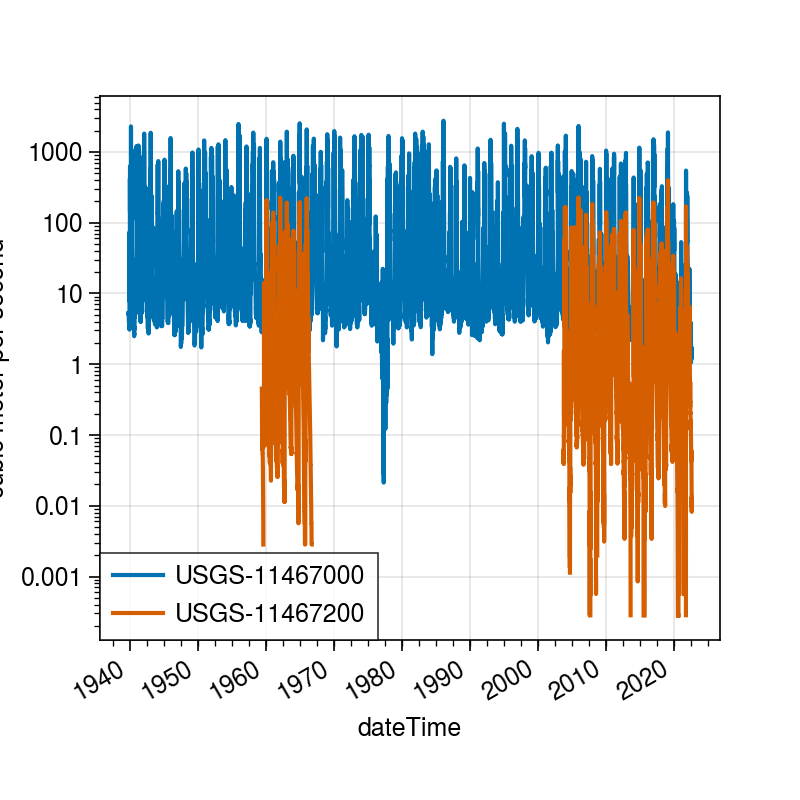

In [19]:
ax = df.plot()
ax.set_ylabel(r"cubic meter per second")
ax.set_yscale("log")

### Updating column names

Let's update column names for these gages based on their locations instead of their USGS gage id. First we'll get name information from the `info` class and then we'll use the station name information to remap the column names.

the `rename()` method accepts a dictionary that is formated `{current_col_name: new_col_name}`

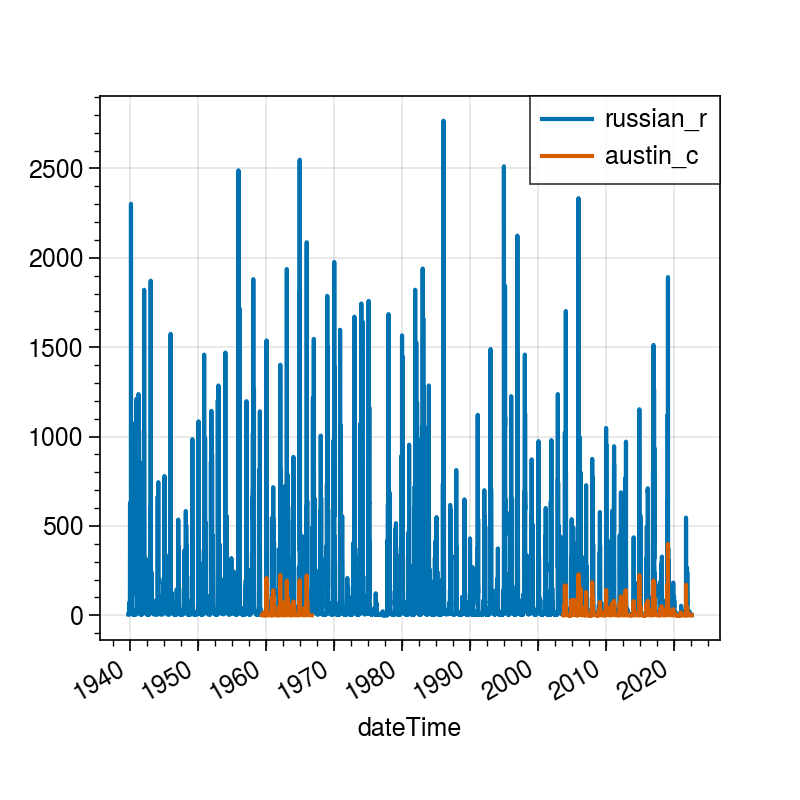

In [20]:
remap = {}
for i in list(df):
    site_no = i.split("-")[-1]
    desc = info[info.site_no == site_no]["station_nm"].values[0]
    colname = "_".join(desc.lower().split()[:2])
    remap[i] = colname
    
df2 = df.rename(columns=remap)
df2.plot();

### Adding a new column of data to the dataframe

Adding new columns of data is relatively simple in pandas. The call signature is similar to a dictionary where df["key"] = "some_array_of_values"

Let's add a year column (water year) to the dataframe by getting the year from the index and adjusting it using `np.where()`

In [21]:
df2['year'] = np.where(df2.index.month >=10, df2.index.year, df2.index.year - 1)

### Manipulating data

Columns in a pandas dataframe can be manipulated similarly to working with a dictionary of numpy arrays. The discharge data units are $\frac{m^3}{s}$, let's accumulate this to daily discharge in $\frac {ft^3}{d}$.

The coversion for this is:

## $ \frac{1 m^3}{s} \times \frac{35.3147 ft^3}{1 m^3} \times \frac{60s}{min} \times \frac{60min}{hour} \times \frac{24hours}{day} \rightarrow \frac{ft^3}{day} $

and then convert that to acre-feet (1 acre-ft = 43559.9)

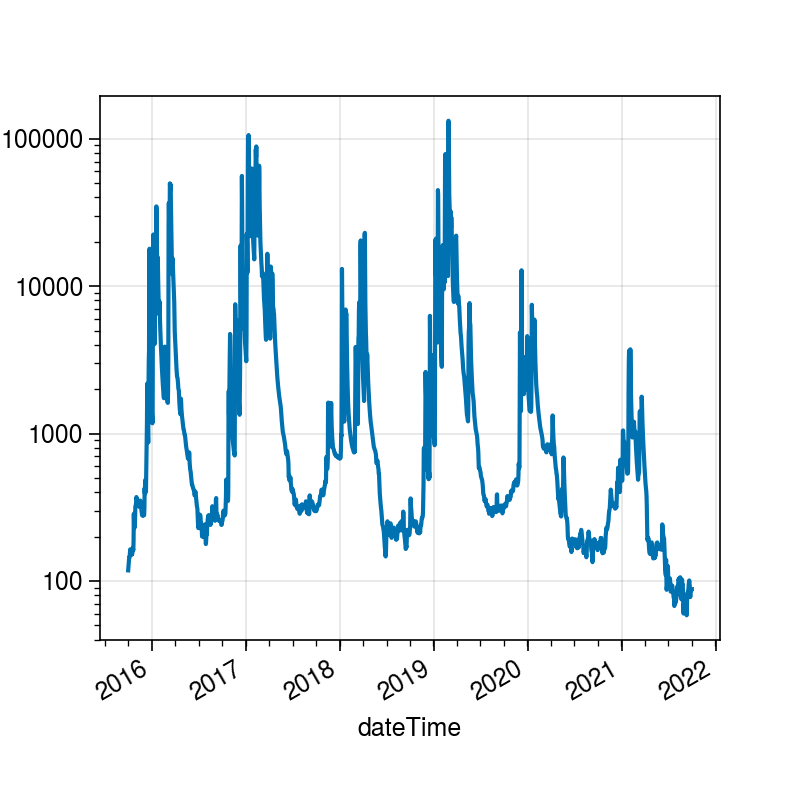

In [22]:
conv = 35.3147 * 60 * 60 * 24
df2["russian_r_cfd"] = df2.russian_r * conv
df2["russian_r_af"] = df2.russian_r_cfd / 43559.9
df2

# now let's plot up discharge from 2018 - 2020
dfplt = df2[(df2["year"] >= 2015) & (df2["year"] <= 2020)]
ax = dfplt["russian_r_af"].plot()
ax.set_yscale("log")


## Class exercise 2:

Using the methods described in the notebook. Convert the discharge for `"austin_c"` from $\frac{m^3}{s}$ acre-ft by adding two additional fields to `df2` named `"austin_c_cfs"` and `"austin_c_af"`. 

After these two fields have been added to df2 use boolean indexing to create a new dataframe from 2015 through 2020. Finally plot the discharge data (in acre-ft) for "austin_cr".

**bonus exercise** try to plot both `"russian_r_af"` and `"austin_c_af"` on the same plot

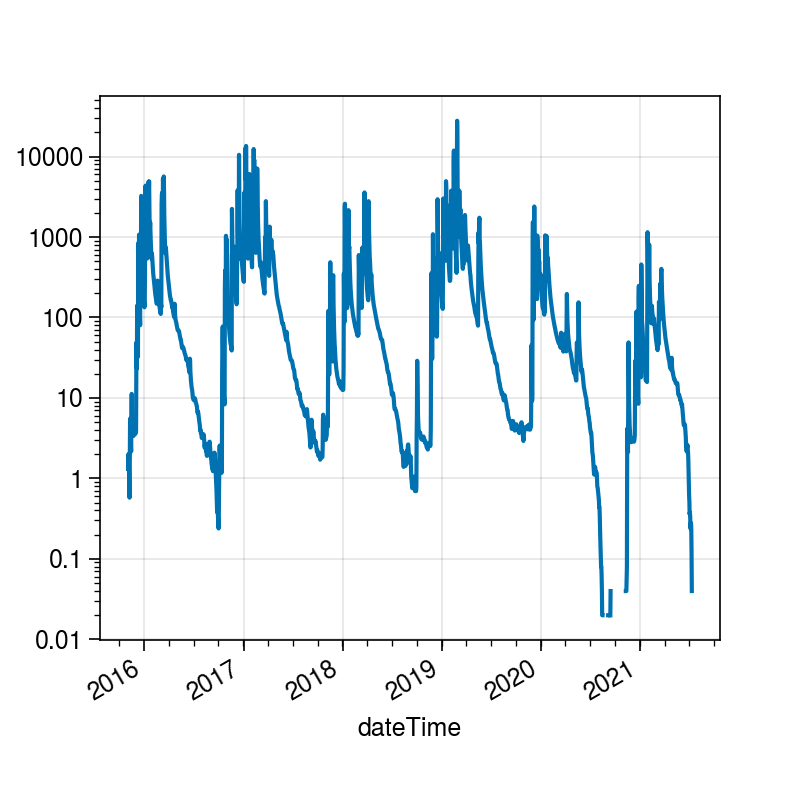

In [23]:
conv = 35.3147 * 60 * 60 * 24
df2["austin_c_cfd"] = df2.austin_c * conv
df2["austin_c_af"] = df2.austin_c_cfd / 43559.9
df2

# now let's plot up discharge from 2018 - 2020
dfplt = df2[(df2["year"] >= 2015) & (df2["year"] <= 2020)]
ax = dfplt["austin_c_af"].plot()
ax.set_yscale("log")


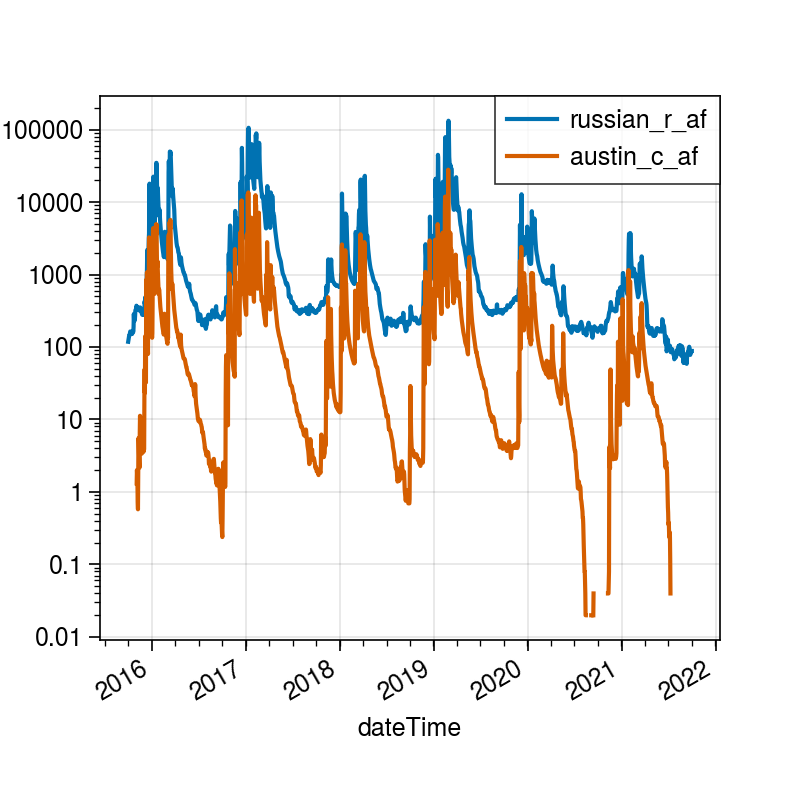

In [24]:
# now let's plot up discharge from 2018 - 2020
dfplt = df2[(df2["year"] >= 2015) & (df2["year"] <= 2020)]
ax = dfplt[["russian_r_af","austin_c_af"]].plot()
ax.set_yscale("log")

### groupby: grouping data and performing mathematical operations on it

`groupby()` is a powerful method that allows for performing statistical operations over a groups of "common" data within a dataframe. 

For this example we'll use it to get mean daily flows for the watershed. Pandas will group all common days of the year with each other and then calculate the mean value of these via the function `.mean()`. `groupby()` also supports other operations such as `.median()`, `.sum()`, `max()`, `min()`, `std()`, and other functions. 

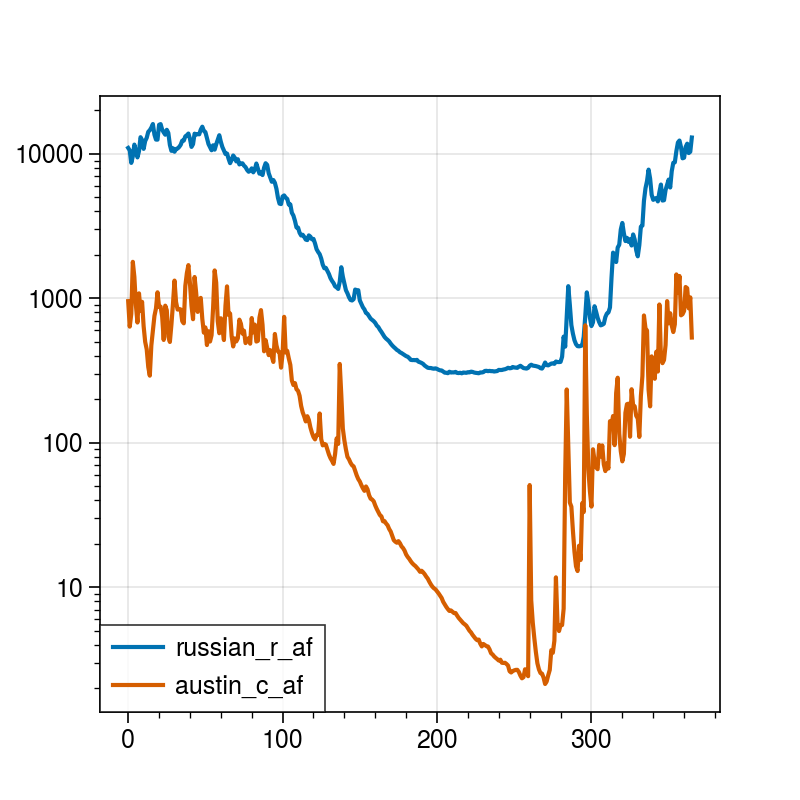

In [25]:
df2["day_of_year"] = df2.index.day_of_year

df_mean_day = df2.groupby(by=["day_of_year"], as_index=False)[["russian_r_af", "austin_c_af"]].mean()
ax = df_mean_day[["russian_r_af", "austin_c_af"]].plot()
ax.set_yscale("log")

We can see that around March flow starts decreasing heavily and doesn't recover until sometime in october. What's going on here? Let's load some climate data and see what's happening.

In [26]:
cimis_file = os.path.join(data_path, "santa_rosa_CIMIS_83.csv")
df_cimis = pd.read_csv(cimis_file)
drop_list = ["qc"] + [f"qc.{i}" for i in range(1, 22)]
df_cimis.drop(columns=drop_list, inplace=True)
df_cimis

,Stn Id,Stn Name,CIMIS Region,Date,Jul,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),...,Rose NNE,Rose ENE,Rose ESE,Rose SSE,Rose SSW,Rose WSW,Rose WNW,Rose NNW,Wind Run (miles),Avg Soil Temp (F)
0,83,Santa Rosa,North Coast Valleys,1/1/1990,1,0.00,0.30,42.0,7.7,48.7,...,0.03,0.02,0.06,0.06,0.04,0.10,0.15,0.14,32.1,46.3
1,83,Santa Rosa,North Coast Valleys,1/2/1990,2,0.06,0.00,236.0,6.1,58.4,...,0.06,0.01,0.04,0.03,0.03,0.06,0.45,1.53,121.0,44.9
2,83,Santa Rosa,North Coast Valleys,1/3/1990,3,0.04,0.00,225.0,5.8,63.0,...,0.08,0.04,0.10,0.04,0.06,0.05,0.21,0.23,44.5,43.3
3,83,Santa Rosa,North Coast Valleys,1/4/1990,4,0.03,0.01,190.0,6.3,56.7,...,0.07,0.07,0.11,0.07,0.03,0.03,0.08,0.09,30.2,42.8
4,83,Santa Rosa,North Coast Valleys,1/5/1990,5,0.04,0.00,192.0,7.2,59.1,...,0.08,0.13,0.33,0.08,0.04,0.08,0.07,0.05,45.2,43.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11948,83,Santa Rosa,North Coast Valleys,9/18/2022,261,0.03,0.77,113.0,16.4,66.8,...,0.01,0.04,0.29,0.51,0.14,0.01,0.00,0.00,197.4,65.2
11949,83,Santa Rosa,North Coast Valleys,9/19/2022,262,0.14,0.02,424.0,15.6,73.9,...,0.09,0.07,0.08,0.17,0.09,0.28,0.15,0.07,108.9,65.9
11950,83,Santa Rosa,North Coast Valleys,9/20/2022,263,0.10,0.00,330.0,13.9,72.6,...,0.08,0.04,0.10,0.11,0.18,0.25,0.15,0.10,79.6,65.8
11951,83,Santa Rosa,North Coast Valleys,9/21/2022,264,0.15,0.07,458.0,14.8,75.5,...,0.09,0.05,0.13,0.16,0.18,0.22,0.08,0.09,103.3,66.7


In [27]:
df_mean_clim = df_cimis.groupby(by=["Jul"], as_index=False)[["ETo (in)", "Precip (in)"]].mean()
df_mean_clim = df_mean_clim.rename(columns={"Jul": "day_of_year"})
df_mean_clim.head()

,day_of_year,ETo (in),Precip (in)
0,1,0.031212,0.335455
1,2,0.031212,0.155152
2,3,0.030303,0.195484
3,4,0.030909,0.190303
4,5,0.034242,0.150000


### Joining two `DataFrames` with an inner join

Inner joins can be made in pandas with the `merge()` method. As inner join, joins two dataframes on a common key or values, when a key or value exists in one dataframe, but not the other that row of data will be excluded from the joined dataframe. 

There are a number of other ways to join dataframes in pandas. Detailed examples and discussion of the different merging methods can be found [here](https://realpython.com/pandas-merge-join-and-concat/)

In [28]:
df_merged = pd.merge(df_mean_day, df_mean_clim, on=["day_of_year",])
df_merged.head()

,day_of_year,russian_r_af,austin_c_af,ETo (in),Precip (in)
0,1,10998.143747,956.098709,0.031212,0.335455
1,2,10569.927684,637.073137,0.031212,0.155152
2,3,8665.813184,779.842322,0.030303,0.195484
3,4,9618.312534,1789.795497,0.030909,0.190303
4,5,11598.205433,1409.889371,0.034242,0.150000


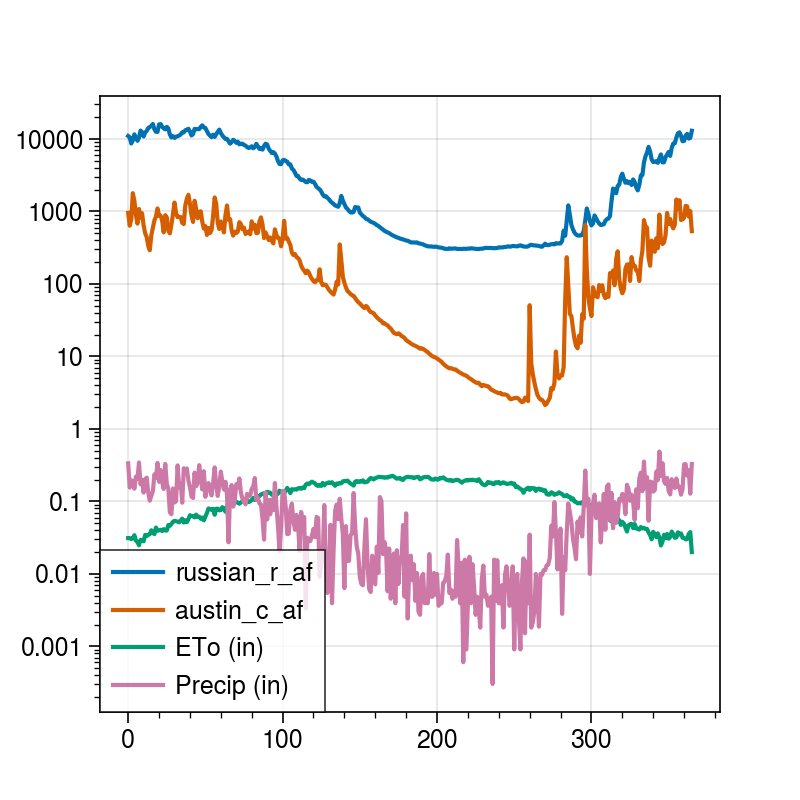

In [29]:
cols = [i for i in list(df_merged) if i != "day_of_year"]
ax = df_merged[cols].plot()
ax.set_yscale("log")

This starts to make a little more sense! We can see that this area gets most of it's precipitation in the winter and early spring. The evapotranspiration curve shows what we'd expect: that there is more evapotranspiration in the summer than the winter. 

Is there anything else we can look at that might give us more insights into this basin? Let's try looking at long term, yearly trends to see what's there.

In [30]:
year = []
for dstr in df_cimis.Date.values:
    mo, d, yr = [int(i) for i in dstr.split("/")]
    if mo < 10:
        year.append(yr - 1)
    else:
        year.append(yr)
df_cimis["year"] = year
df_cimis.head()

,Stn Id,Stn Name,CIMIS Region,Date,Jul,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),...,Rose ENE,Rose ESE,Rose SSE,Rose SSW,Rose WSW,Rose WNW,Rose NNW,Wind Run (miles),Avg Soil Temp (F),year
0,83,Santa Rosa,North Coast Valleys,1/1/1990,1,0.00,0.30,42.0,7.7,48.7,...,0.02,0.06,0.06,0.04,0.10,0.15,0.14,32.1,46.3,1989
1,83,Santa Rosa,North Coast Valleys,1/2/1990,2,0.06,0.00,236.0,6.1,58.4,...,0.01,0.04,0.03,0.03,0.06,0.45,1.53,121.0,44.9,1989
2,83,Santa Rosa,North Coast Valleys,1/3/1990,3,0.04,0.00,225.0,5.8,63.0,...,0.04,0.10,0.04,0.06,0.05,0.21,0.23,44.5,43.3,1989
3,83,Santa Rosa,North Coast Valleys,1/4/1990,4,0.03,0.01,190.0,6.3,56.7,...,0.07,0.11,0.07,0.03,0.03,0.08,0.09,30.2,42.8,1989
4,83,Santa Rosa,North Coast Valleys,1/5/1990,5,0.04,0.00,192.0,7.2,59.1,...,0.13,0.33,0.08,0.04,0.08,0.07,0.05,45.2,43.7,1989


In [31]:
df2.head()

,russian_r,austin_c,year,russian_r_cfd,russian_r_af,austin_c_cfd,austin_c_af,day_of_year
dateTime,,,,,,,,
1939-10-01 08:00:00+00:00,5.238617,NaN,1939,1.598402e+07,366.943337,NaN,NaN,274
1939-10-02 08:00:00+00:00,5.238617,NaN,1939,1.598402e+07,366.943337,NaN,NaN,275
1939-10-03 08:00:00+00:00,5.238617,NaN,1939,1.598402e+07,366.943337,NaN,NaN,276
1939-10-04 08:00:00+00:00,5.238617,NaN,1939,1.598402e+07,366.943337,NaN,NaN,277
1939-10-05 08:00:00+00:00,5.238617,NaN,1939,1.598402e+07,366.943337,NaN,NaN,278


### `.aggregate()`

The pandas `.aggregate()` can be used with `.groupy()` to perform multiple statistical operations.

Example useage could be:

```python
    
    agdf = df2.groupby(by=["day_of_year"], as_index=False)["austin_c_af"].aggregate([np.min, np.max, np.mean, np.std])
```

And would return a dataframe grouped by the day of year and take the min, max, mean, and standard deviation of these data.

## Class exercise 3: groupy, aggregate, and merge

For this exercise we need to produce yearly mean and standard deviation flows for the `russian_r_af` variable and merge the data with yearly mean precipitation and evapotranspiration  

**Hints:**  
   - `df2` and `df_cimis` are the dataframes these operations should be performed on  
   - use `.groupby()` to group by the year and do `precip` and `ETo` in seperate groupby routines
   - rename the columns in the ETo aggregated dataframe and the Precip dataframe to `mean_et`, `std_et`, `mean_precip`, `std_precip`
   - `np.mean` and `np.std` can be used to calculate mean and std flows  
   
Name your final joined dataframe `df_yearly`

In [32]:
dfg0 = df2.groupby(by=["year"], as_index=False)["russian_r_af"].aggregate([np.mean, np.std])
dfg1 = df_cimis.groupby(by=["year"], as_index=False)["ETo (in)"].aggregate([np.mean, np.std])
dfg2 = df_cimis.groupby(by=["year"], as_index=False)["Precip (in)"].aggregate([np.mean, np.std])

dfm1 = pd.merge(dfg0, dfg1, on=["year"], suffixes=(None, "_et"))
df_yearly = pd.merge(dfm1, dfg2, on=["year"], suffixes=(None, "_precip"))

df_yearly

,mean,std,mean_et,std_et,mean_precip,std_precip
year,,,,,,
1989,1388.135368,2703.400862,0.160513,0.080539,0.067473,0.284019
1990,2105.132595,7210.545933,0.113671,0.067419,0.081642,0.353434
1991,2180.264477,5581.178574,0.117268,0.067521,0.086940,0.233645
1992,5746.253861,11726.325719,0.122712,0.077676,0.128329,0.312310
1993,1528.092800,3052.874341,0.121781,0.073195,0.060168,0.225893
1994,9581.543988,22426.367428,0.113178,0.076706,0.151479,0.433991
1995,5575.853307,10440.124191,0.122814,0.078691,0.112596,0.416613
1996,5600.845940,16501.525860,0.129699,0.077105,0.102959,0.348520
1997,8587.952182,16139.663705,0.111589,0.075997,0.153068,0.383740


Lets examine the long term flow record for the Russian River

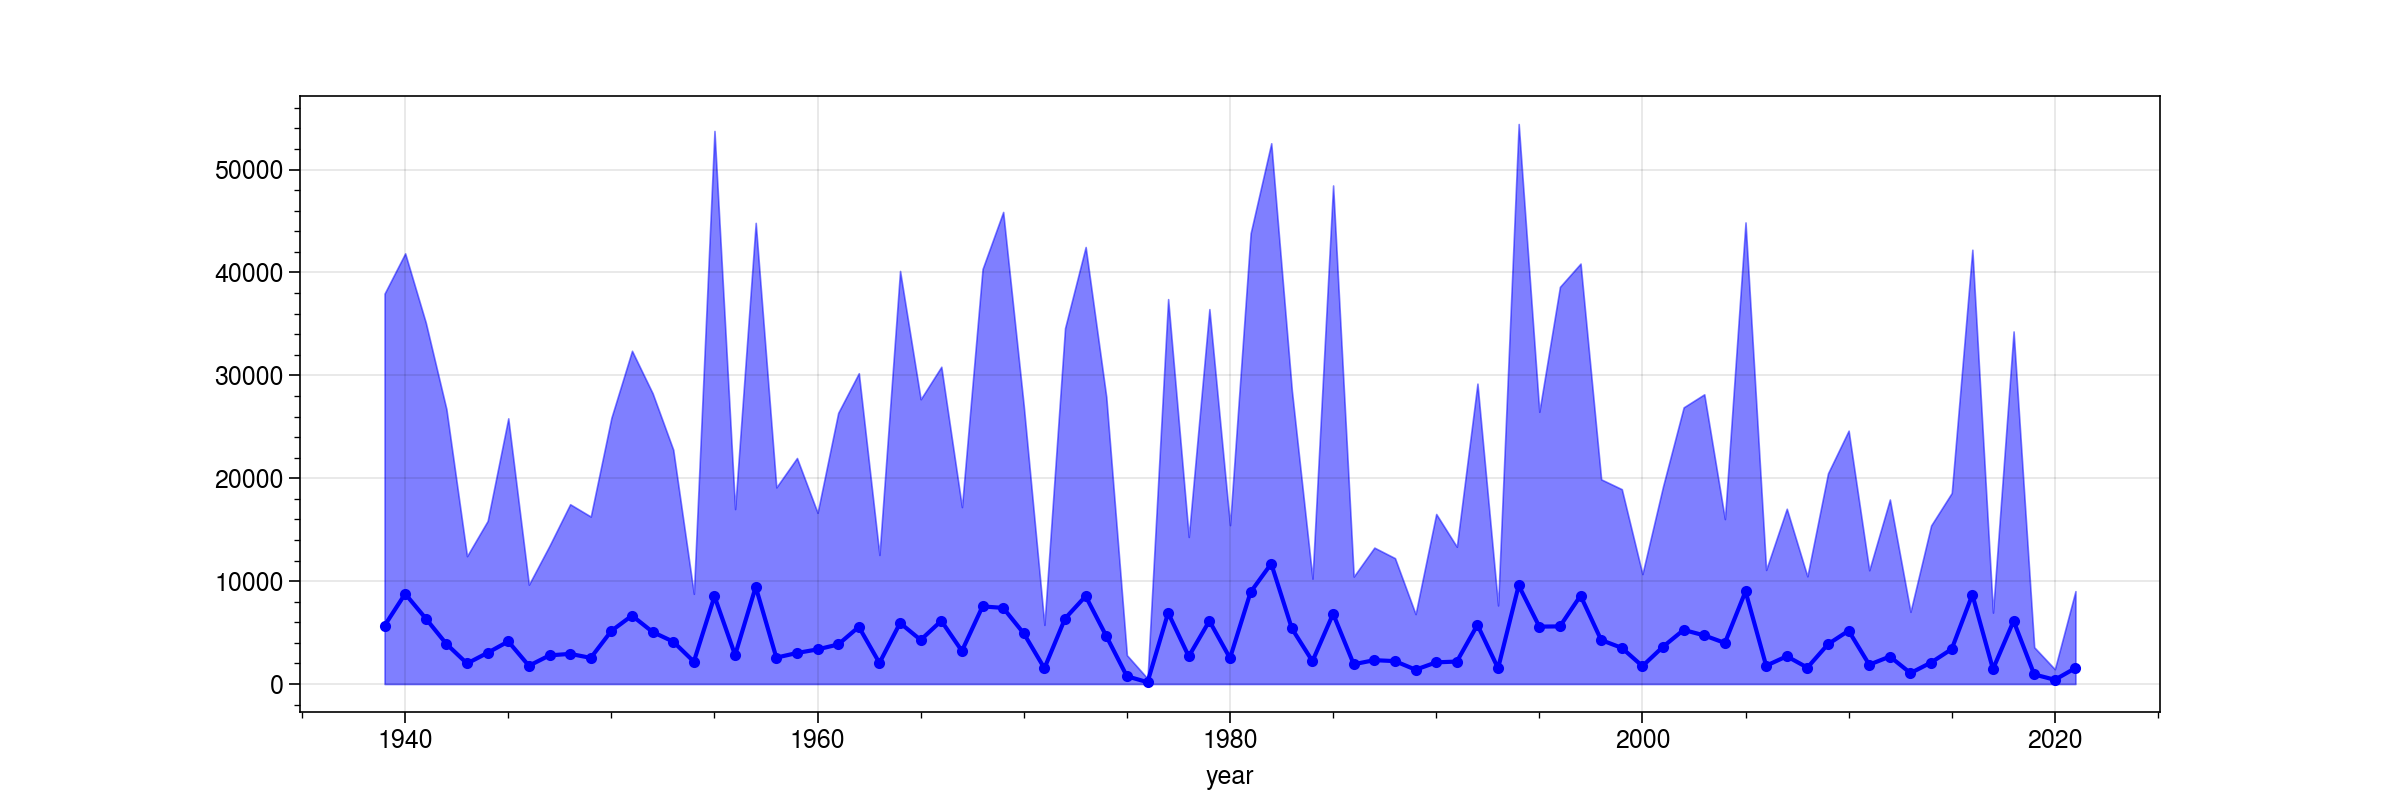

In [33]:
df_y_flow = df2.groupby(by=["year"], as_index=False)["russian_r_af"].aggregate([np.mean, np.std])

fig = plt.figure(figsize=(12,4))

lower_ci = df_y_flow["mean"] - 2 * df_y_flow['std']
lower_ci = np.where(lower_ci < 0, 0, lower_ci)
upper_ci = df_y_flow["mean"] + 2 * df_y_flow['std']
ax = df_y_flow["mean"].plot(style="b.-")
ax.fill_between(df_y_flow.index, lower_ci, upper_ci, color="b", alpha=0.5);

From this plot it looks like the long term trend in yearly discharge in the Russian River has been decreasing. We will revisit and test this later. 

First let's see if there are any relationships between yearly discharge and climate

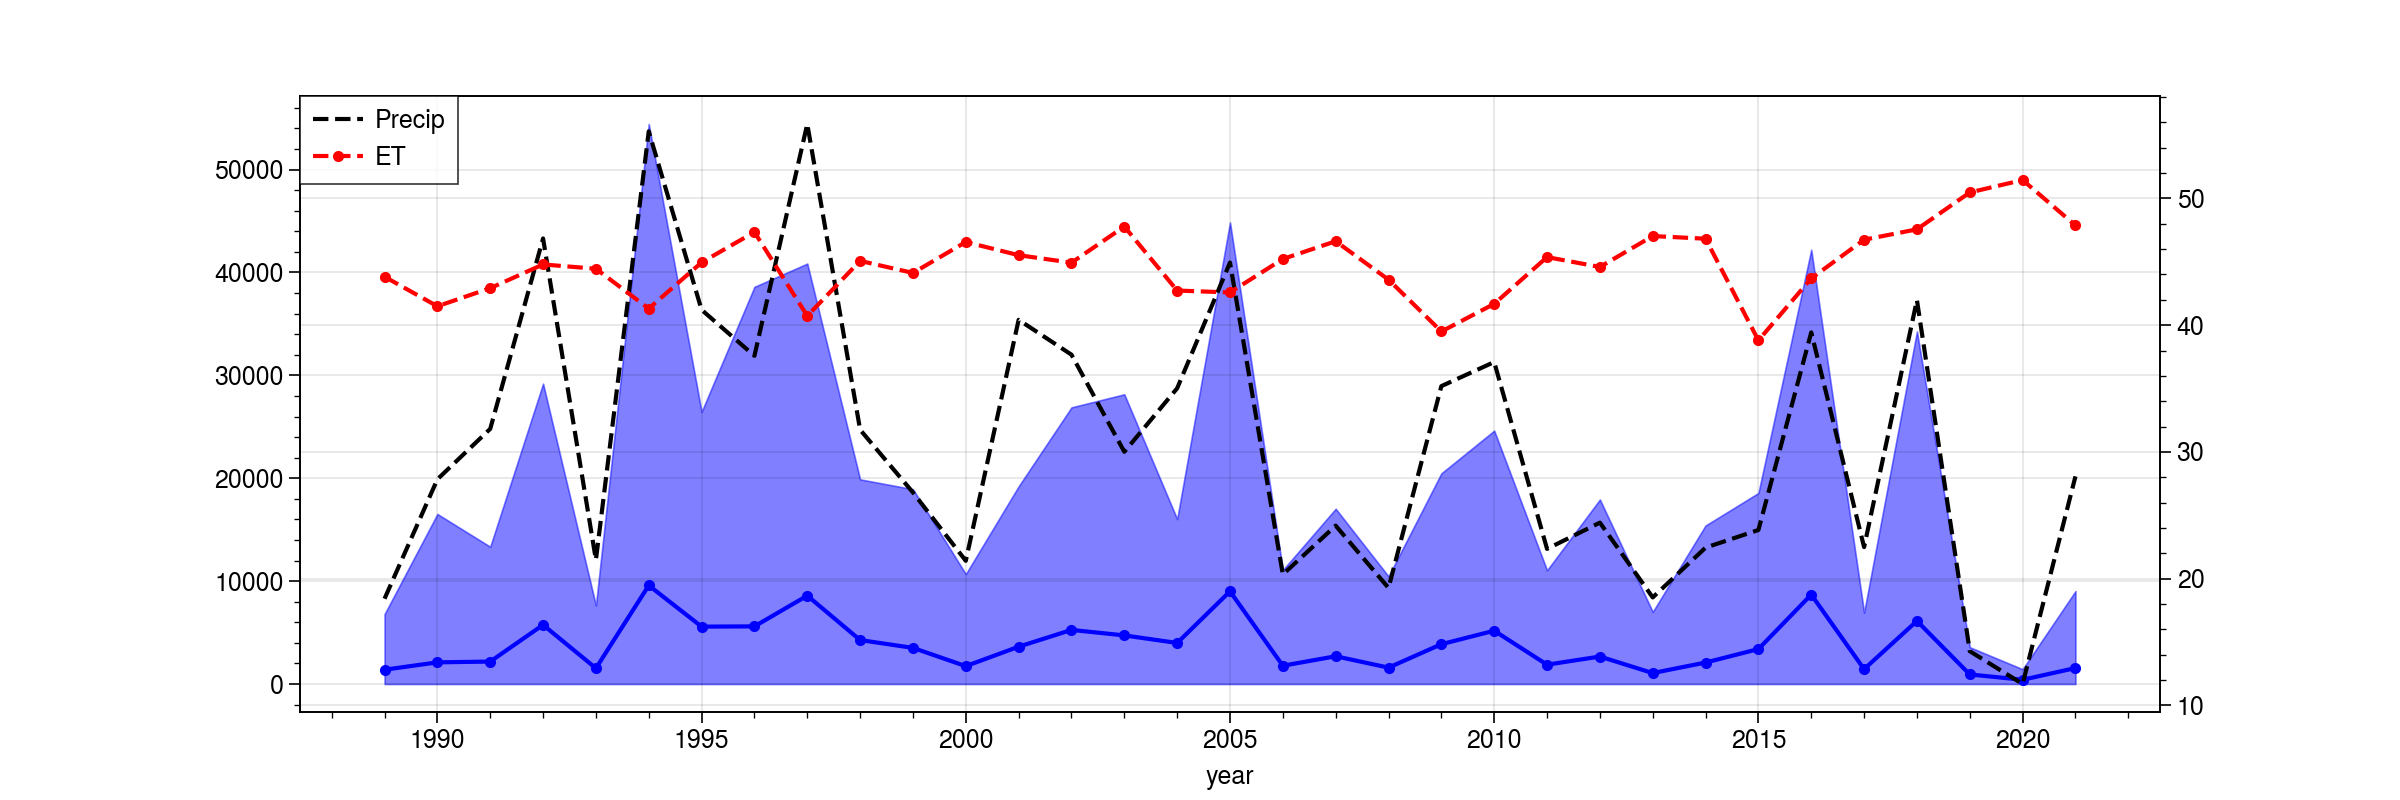

In [34]:
dfg0 = df2.groupby(by=["year"], as_index=False)["russian_r_af"].aggregate([np.mean, np.std, np.sum])
dfg1 = df_cimis.groupby(by=["year"], as_index=False)["ETo (in)"].aggregate([np.mean, np.std, np.sum])
dfg2 = df_cimis.groupby(by=["year"], as_index=False)["Precip (in)"].aggregate([np.mean, np.std, np.sum])
dfm1 = pd.merge(dfg0, dfg1, on=["year"], suffixes=(None, "_et"))
df_yearly = pd.merge(dfm1, dfg2, on=["year"], suffixes=(None, "_precip"))

fig = plt.figure(figsize=(12,4))

lower_ci = df_yearly["mean"] - 2 * df_yearly['std']
lower_ci = np.where(lower_ci < 0, 0, lower_ci)
upper_ci = df_yearly["mean"] + 2 * df_yearly['std']
ax = df_yearly["mean"].plot(style="b.-", label="flow_af")
ax.fill_between(df_yearly.index, lower_ci, upper_ci, color="b", alpha=0.5)
ax2 = ax.twinx()
ax2.plot(df_yearly.index, df_yearly.sum_precip, "k--", lw=1.5, label="Precip")
ax2.plot(df_yearly.index, df_yearly.sum_et, "r.--", lw=1.5, label="ET")
plt.legend()
plt.show();

As expected, precipitation amount is the main driver of the yearly discharge regime here

### Baseflow separation

Baseflow separation is a method to separate the quick response hydrograph (storm runoff) from the long term flow. We're going to go back to the complete daily dataset to perform this operation. The following cell contains a low pass filtration method that is used for digital baseflow separation. We'll use these in our analysis

In [35]:
def _baseflow_low_pass_filter(arr, beta, enforce):
    """
    Private method to apply digital baseflow separation filter
    (Lyne & Hollick, 1979; Nathan & Mcmahon, 1990;
    Boughton, 1993; Chapman & Maxwell, 1996).

    This method should not be called by the user!

    Method removes "spikes" which would be consistent with storm flow
    events from data.

    Parameters
    ----------
    arr : np.array
        streamflow or municipal pumping time series

    beta : float
        baseflow filtering parameter that ranges from 0 - 1
        values in 0.8 - 0.95 range used in literature for
        streamflow baseflow separation

    enforce : bool
        enforce physical constraint of baseflow less than measured flow

    Returns
    -------
        np.array of filtered data
    """
    # prepend 10 records to data for initial spin up
    # these records will be dropped before returning data to user
    qt = np.zeros((arr.size + 10,), dtype=float)
    qt[0:10] = arr[0:10]
    qt[10:] = arr[:]

    qdt = np.zeros((arr.size + 10,), dtype=float)
    qbf = np.zeros((arr.size + 10,), dtype=float)

    y = (1. + beta) / 2.

    for ix in range(qdt.size):
        if ix == 0:
            qbf[ix] = qt[ix]
            continue

        x = beta * qdt[ix - 1]
        z = qt[ix] - qt[ix - 1]
        qdt[ix] = x + (y * z)

        qb = qt[ix] - qdt[ix]
        if enforce:
            if qb > qt[ix]:
                qbf[ix] = qt[ix]
            else:
                qbf[ix] = qb

        else:
            qbf[ix] = qb

    return qbf[10:]


def baseflow_low_pass_filter(arr, beta=0.9, T=1, enforce=True):
    """
    User method to apply digital baseflow separation filter
    (Lyne & Hollick, 1979; Nathan & Mcmahon, 1990;
    Boughton, 1993; Chapman & Maxwell, 1996).

    Method removes "spikes" which would be consistent with storm flow
    events from data.

    Parameters
    ----------
    arr : np.array
        streamflow or municipal pumping time series

    beta : float
        baseflow filtering parameter that ranges from 0 - 1
        values in 0.8 - 0.95 range used in literature for
        streamflow baseflow separation

    T : int
        number of recursive filtering passes to apply to the data

    enforce : bool
        enforce physical constraint of baseflow less than measured flow

    Returns
    -------
        np.array of baseflow
    """
    for _ in range(T):
        arr = _baseflow_low_pass_filter(arr, beta, enforce)

    return arr


## Class exercise 4: baseflow separation

Using the full dataframe discharge dataframe, `df2`, get the baseflows for the Russian River (in acre-ft) and add these to the dataframe as a new column named `russian_bf_af`.

The function `baseflow_low_pass_filter()` will be used to perform baseflow. This function takes a numpy array of stream discharge and runs a digital low pass filtration method to calculate baseflow. 

After performing baseflow seperation plot both the baseflow and the total discharge for the years 2015 - 2017.

**Hints:**
   - make sure to use the `.values` property when you get discharge data from the pandas dataframe
   - feel free to play with the input parameters `beta` and `T`. 
      - `beta` is commonly between 0.8 - 0.95 for hydrologic problems.
      - `T` is the number of filter passes over the data, therefore increasing `T` will create a smoother profile. I recommend starting with a `T` value of around 5 and adjusting it to see how it changes the baseflow profile.

<Figure size 1500x1000 with 0 Axes>

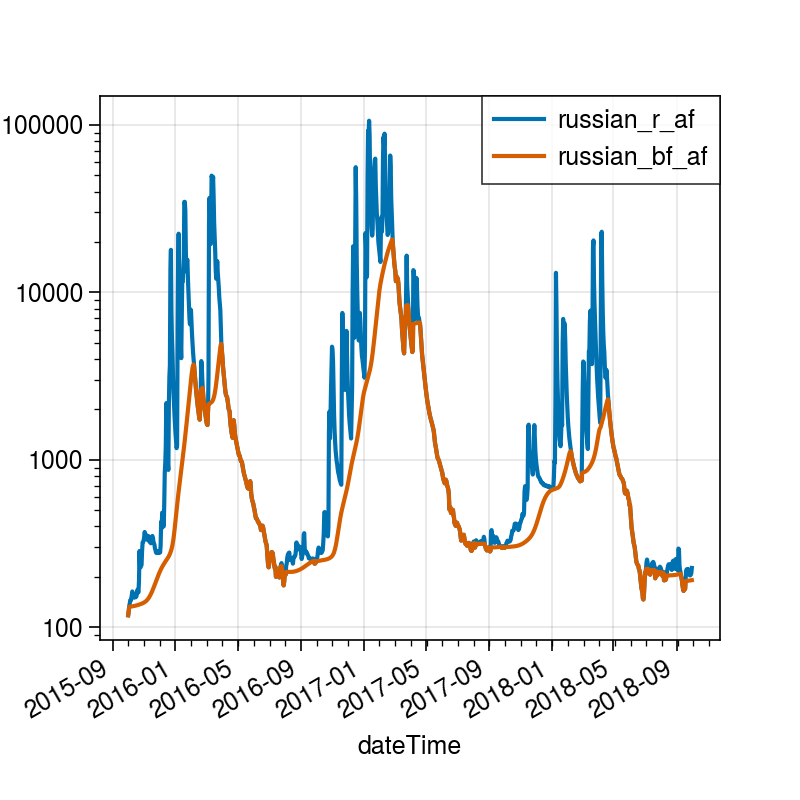

In [36]:
baseflow = baseflow_low_pass_filter(df2["russian_r_af"].values, beta=0.90, T=5)
df2["russian_bf_af"] = baseflow

fig = plt.figure(figsize=(15, 10))
tdf = df2[(df2.year >= 2015) & (df2.year <= 2017)]
ax = tdf[["russian_r_af", "russian_bf_af"]].plot()
ax.set_yscale("log");

## Looking at trends and seasonal cycles in the data with `statsmodels`

`statsmodels` is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. For more information on `statsmodels` and it's many features visit [the getting started guide](https://www.statsmodels.org/dev/gettingstarted.html)

For this example we'll be using time series analysis to perform a seasonal decomposition using moving averages. The `statsmodels` function `seasonal_decompose` will perform this analysis and return the data trend, seasonal fluctuations, and residuals.

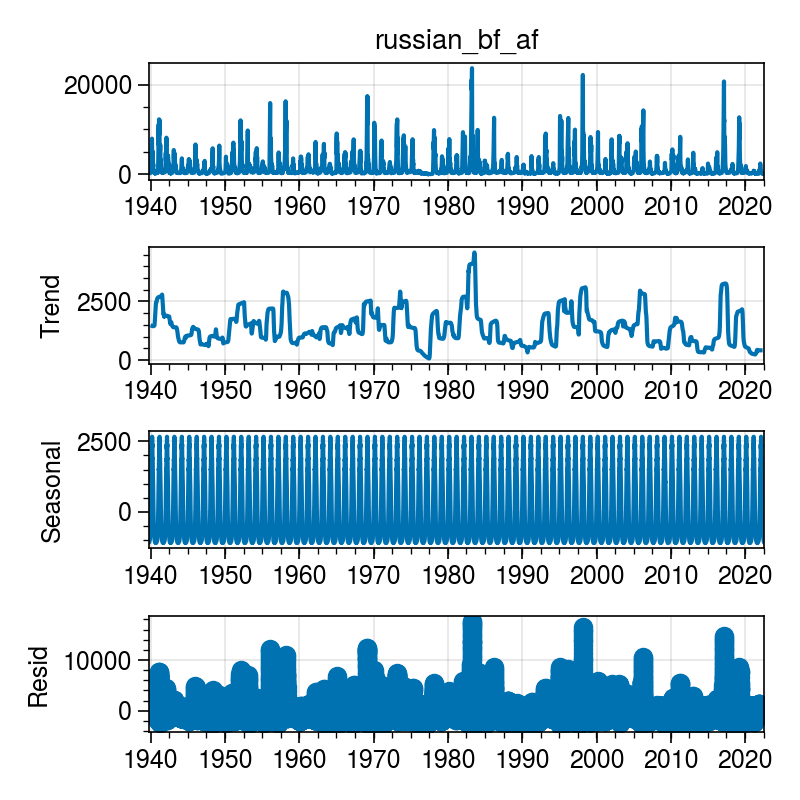

In [37]:
df2["russian_bf_af"] = baseflow_low_pass_filter(df2["russian_r_af"].values, beta=0.9, T=5)
# drop nan values prior to running decomposition
dfsm = df2[df2['russian_bf_af'].notna()]

dfsm.head()
# decompose
decomposition = sm.tsa.seasonal_decompose(dfsm["russian_bf_af"], period=365, model="additive")
 
decomposition.plot()
mpl.rcParams['figure.figsize'] = [14, 14];

Now let's plot our baseflow trend against the baseflow we calculated 

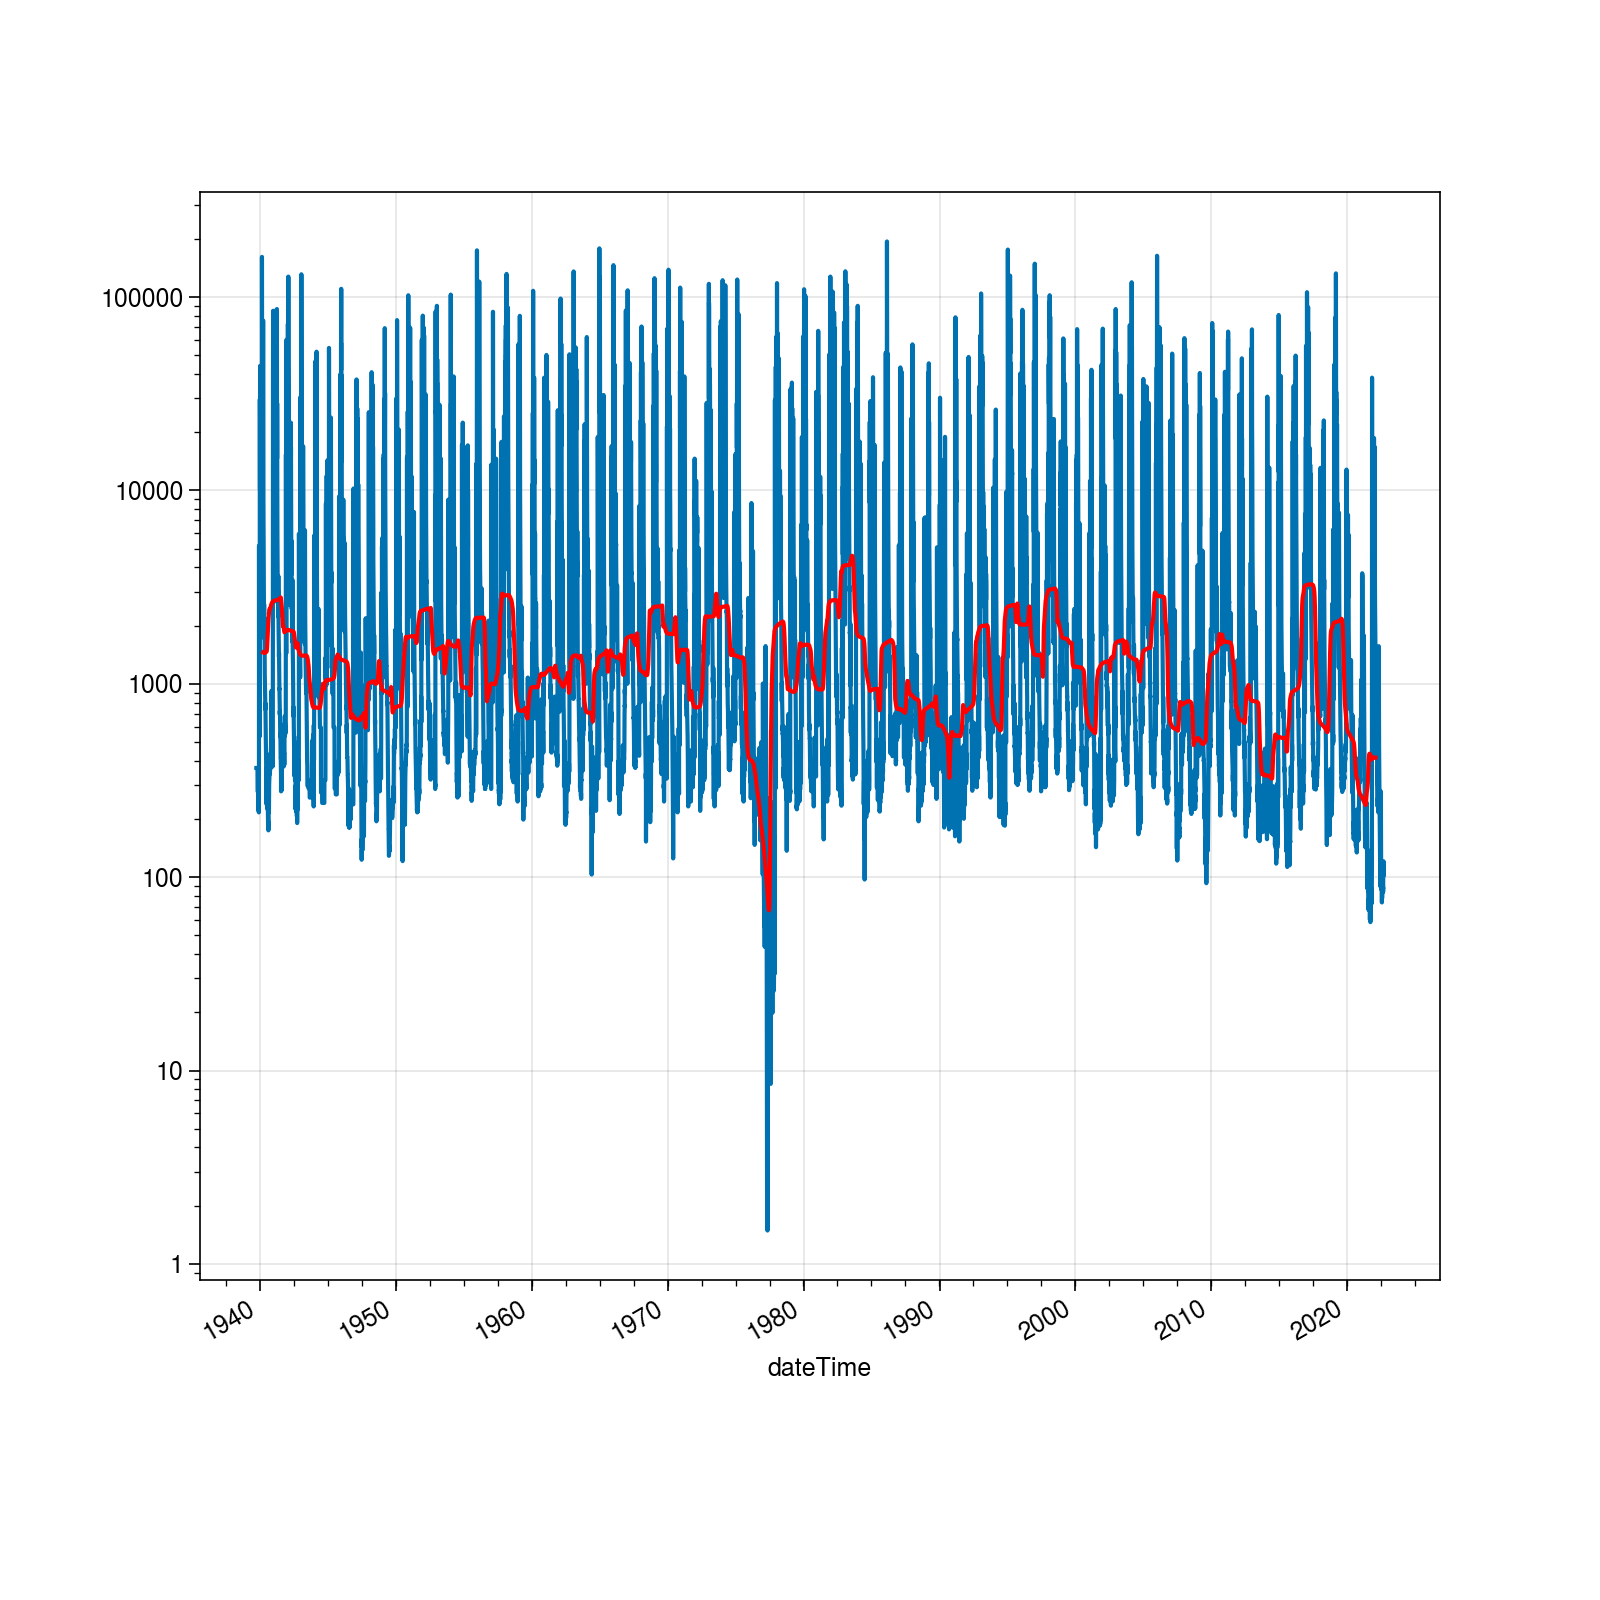

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))

ax = df2["russian_r_af"].plot(ax=ax)
ax.plot(decomposition.trend.index, decomposition.trend, "r-", lw=1.5)
ax.set_yscale('log')
plt.savefig("russian_river.png")


What's going on at the end of the 1970's? Why is the baseflow trend so low and peak flows are also low? 

From ["California's Most Significant Droughts"](https://cawaterlibrary.net/wp-content/uploads/2017/05/CalSignficantDroughts_v10_int.pdf), Chapter 3 

The setting for the 1976-77 drought differed significantly from the dry times of the 1920s-30s. Although
only a two-year event, its hydrology was severe.
Based on 114 years of computed statewide runoff,
1977 occupies rank 114 (driest year) and 1976 is in
rank 104. The drought was notable for the impacts
experienced by water agencies that were unprepared
for such conditions.  One reason for the lack of
preparedness was the perception of relatively ample
water supplies in most areas of the state. 

We can also see the analysis that there is an overall reduction in baseflow from 1940's to the 2020's

### Writing yearly plots of data to a PDF document

We can write the plots we make with pandas to a multipage pdf using matplotlib's `PdfPages`. For this example we'll make yearly plots of all of the discharge, baseflow, and baseflow trend and bundle them into a single pdf document.

In [39]:
# add the decomposition trend to the dataframe to make plotting easy
df2["baseflow_trend"] = decomposition.trend

pdf_file = os.path.join(data_path, "all_years_russian.pdf")
with PdfPages(pdf_file) as outpdf:
    for year in sorted(df2.year.unique()):
        plt.figure()
        tdf = df2[df2.year == year]
        tdf[["russian_r_af", "russian_bf_af", "baseflow_trend"]].plot()
        plt.xlabel("date")
        plt.ylabel("acre-feet")
        plt.ylim([1, 300000])
        plt.yscale("log")
        plt.tight_layout()
        outpdf.savefig()
        plt.close('all')

Go into the "data/pandas" and open up the file "all_years_russian.pdf" to check out the plots.

## Back to the basics:

Now that we've done some analysis on real data, let's go back to the basic and briefly discuss how to adjust data values in pandas


### Adjusting a whole column of data values

Because pandas series objects (columns) are built off of numpy, we can perform mathematical operations in place on a whole column similarly to numpy arrays


In [40]:
df3 = df2.copy()
# Adding values
df3["russian_r"] += 10000

# Subtracting values
df3["russian_r"] -= 10000

# multiplication
df3["russian_r"] *= 5

# division
df3["russian_r"] /= 5

# more complex operations
df3["russian_r"] = np.log10(df3["russian_r"].values)
df3.head()

,russian_r,austin_c,year,russian_r_cfd,russian_r_af,austin_c_cfd,austin_c_af,day_of_year,russian_bf_af,baseflow_trend
dateTime,,,,,,,,,,
1939-10-01 08:00:00+00:00,0.719217,NaN,1939,1.598402e+07,366.943337,NaN,NaN,274,366.943337,NaN
1939-10-02 08:00:00+00:00,0.719217,NaN,1939,1.598402e+07,366.943337,NaN,NaN,275,366.943337,NaN
1939-10-03 08:00:00+00:00,0.719217,NaN,1939,1.598402e+07,366.943337,NaN,NaN,276,366.943337,NaN
1939-10-04 08:00:00+00:00,0.719217,NaN,1939,1.598402e+07,366.943337,NaN,NaN,277,366.943337,NaN
1939-10-05 08:00:00+00:00,0.719217,NaN,1939,1.598402e+07,366.943337,NaN,NaN,278,366.943337,NaN


### updating values by position

We can update single or multiple values by their position in the dataframe using `.iloc`

In [41]:
df3.iloc[0, 1] = 999
df3.head()

,russian_r,austin_c,year,russian_r_cfd,russian_r_af,austin_c_cfd,austin_c_af,day_of_year,russian_bf_af,baseflow_trend
dateTime,,,,,,,,,,
1939-10-01 08:00:00+00:00,0.719217,999.0,1939,1.598402e+07,366.943337,NaN,NaN,274,366.943337,NaN
1939-10-02 08:00:00+00:00,0.719217,NaN,1939,1.598402e+07,366.943337,NaN,NaN,275,366.943337,NaN
1939-10-03 08:00:00+00:00,0.719217,NaN,1939,1.598402e+07,366.943337,NaN,NaN,276,366.943337,NaN
1939-10-04 08:00:00+00:00,0.719217,NaN,1939,1.598402e+07,366.943337,NaN,NaN,277,366.943337,NaN
1939-10-05 08:00:00+00:00,0.719217,NaN,1939,1.598402e+07,366.943337,NaN,NaN,278,366.943337,NaN


### updating values based on location

We can update values in the dataframe based on their index and column headers too using `.loc`

In [42]:
df3.loc[df3.index[0], 'russian_r'] *= 100
df3.head()

,russian_r,austin_c,year,russian_r_cfd,russian_r_af,austin_c_cfd,austin_c_af,day_of_year,russian_bf_af,baseflow_trend
dateTime,,,,,,,,,,
1939-10-01 08:00:00+00:00,71.921662,999.0,1939,1.598402e+07,366.943337,NaN,NaN,274,366.943337,NaN
1939-10-02 08:00:00+00:00,0.719217,NaN,1939,1.598402e+07,366.943337,NaN,NaN,275,366.943337,NaN
1939-10-03 08:00:00+00:00,0.719217,NaN,1939,1.598402e+07,366.943337,NaN,NaN,276,366.943337,NaN
1939-10-04 08:00:00+00:00,0.719217,NaN,1939,1.598402e+07,366.943337,NaN,NaN,277,366.943337,NaN
1939-10-05 08:00:00+00:00,0.719217,NaN,1939,1.598402e+07,366.943337,NaN,NaN,278,366.943337,NaN


## Class exercise 5: setting data

The russian river discharge in cubic feet per day highly variable and represented by large numbers. To make this data easier to read and plot, update it to a log10 representation.

Then use either a location based method to change the value in austin_c on 10-4-1939 to 0.

Finally display the first 5 records in the notebook.

In [43]:
df3["russian_r_cfd"] = np.log10(df3["russian_r_cfd"])
df3.loc[df3.index[3], "austin_c"] = 0
df3.head()

,russian_r,austin_c,year,russian_r_cfd,russian_r_af,austin_c_cfd,austin_c_af,day_of_year,russian_bf_af,baseflow_trend
dateTime,,,,,,,,,,
1939-10-01 08:00:00+00:00,71.921662,999.0,1939,7.203686,366.943337,NaN,NaN,274,366.943337,NaN
1939-10-02 08:00:00+00:00,0.719217,NaN,1939,7.203686,366.943337,NaN,NaN,275,366.943337,NaN
1939-10-03 08:00:00+00:00,0.719217,NaN,1939,7.203686,366.943337,NaN,NaN,276,366.943337,NaN
1939-10-04 08:00:00+00:00,0.719217,0.0,1939,7.203686,366.943337,NaN,NaN,277,366.943337,NaN
1939-10-05 08:00:00+00:00,0.719217,NaN,1939,7.203686,366.943337,NaN,NaN,278,366.943337,NaN


## Now for some powerful analysis using fourier analysis to extract the data's signal.

Some background for your evening viewing: https://youtu.be/spUNpyF58BY

We have to detrend the data for fast fourier transforms to work properly. Here's a discussion on why: 

https://groups.google.com/forum/#!topic/comp.dsp/kYDZqetr_TU

Fortunately we can easily do this in python using scipy!

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html

Let's create a new dataframe with only the data we're interested in analysing.

In [49]:
df_data = df2[["russian_r_af", "year"]]
df_data = df_data.rename(columns={"russian_r_af": "Q"})
df_data.describe()

,Q,year
count,30286.000000,30287.000000
mean,4257.483125,1979.960049
std,11347.298658,23.936726
min,1.487608,1939.000000
25%,345.125084,1959.000000
50%,676.365826,1980.000000
75%,2657.859846,2001.000000
max,193785.751450,2021.000000
